# Dataset

In [2]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.pipeline import make_pipeline, _name_estimators
from sklearn.decomposition import PCA, KernelPCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, make_scorer, f1_score, precision_score, recall_score, accuracy_score, roc_curve, auc, roc_auc_score
from scipy import interp
from sklearn.base import clone, ClassifierMixin, BaseEstimator
from itertools import combinations
import operator




In [3]:
df_magic = pd.read_csv('magic04.data', header = None)
df_magic.columns = ['Lenght', 'Width', 'Size', 'Conc', 'Conc1', 'Asym', 'M3Long', 'M3Trans', 'Alpha', 'Dist', 'Class']
le = LabelEncoder()
y = le.fit_transform(df_magic['Class'].values)
df_magic['Class'] = y



In [4]:
df_magic

,Lenght,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,Class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,0
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,0
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,0
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,0
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,0
...,...,...,...,...,...,...,...,...,...,...,...
19015,21.3846,10.9170,2.6161,0.5857,0.3934,15.2618,11.5245,2.8766,2.4229,106.8258,1
19016,28.9452,6.7020,2.2672,0.5351,0.2784,37.0816,13.1853,-2.9632,86.7975,247.4560,1
19017,75.4455,47.5305,3.4483,0.1417,0.0549,-9.3561,41.0562,-9.4662,30.2987,256.5166,1
19018,120.5135,76.9018,3.9939,0.0944,0.0683,5.8043,-93.5224,-63.8389,84.6874,408.3166,1


In [5]:
X,y  = df_magic.iloc[:,:-1].values, df_magic.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.3, random_state= 0, stratify= y, shuffle= True)
X_train = X_train[:1000]
X_test = X_test[:300]
y_train = y_train[:1000]
y_test = y_test[:300]



# Functions

In [9]:
def ROC_Curve(X,y, estimator):
    cv = list(StratifiedKFold(n_splits  = 10, random_state = 1, shuffle= True).split(X, y))
    fig  = plt.figure(figsize = (7,5))
    mean_tpr = 0.0
    mean_fpr = np.linspace(0,1,100)
    all_tpr = []

    for i, (train, test) in enumerate(cv):
        probas = estimator.fit(X[train], y[train]).predict_proba(X_train[test])
        fpr, tpr, thresholds = roc_curve(y[test], probas[:,1],pos_label= 1)
        mean_tpr += np.interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr,tpr)
        plt.plot(fpr,tpr, label = 'ROC fold %d (area = %0.2f)' % (i+1, roc_auc))
    plt.plot([0,1], [0,1], linestyle = '--', color = (0.6,0.6,0.6), label = 'Random guessing')
    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--', label = 'Mean ROC (area = %0.2f)' % mean_auc, lw = 2)
    plt.plot([0,0,1], [0,1,1], linestyle = ':', label = 'Perfect performance')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend(loc = 'lower right')
    plt.show()

In [10]:
class SBS():
    def __init__(self, estimator, k_features, scoring = accuracy_score, test_size = 0.25, random_state = 1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
    def fit(self, X,y):
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.3, random_state= self.random_state)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train,y_train, X_test, y_test,self.indices_)
        self.scores_ = [score]
        
        while dim > self.k_features:
            scores = []
            subsets = []
            
            for p in combinations(self.indices_, r = dim-1):
                score = self._calc_score(X_train, y_train, X_test, y_test, p)

                scores.append(score)
                subsets.append(p)
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        return self
    
    def transform(self,X):
        return X[:, self.indices_]
    
    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score  
          

In [11]:
class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    #Abbiamo utilizzato due classi come genitori per avere alcune funzionalità a gratis
    def __init__(self, classifiers, vote = 'classlabel', weights = None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote 
        self.weights = weights
    
    def fit(self, X,y):
        if self.vote not in {'probability', 'classlabel'}:
            raise ValueError('vote must be probability or class label')
        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal')
        self.labelenc_ = LabelEncoder()
        self.labelenc_.fit(y) #qui semplicemente le fitta nel senso trova le singole classi
        self.classes_ = self.labelenc_.classes_ #qua le restituisce sotto  forma di arrat
        self.classifiers_ = []

        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.labelenc_.transform(y)) #qua le trasforma in numeir interi da 0 
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis = 1)
        else: 

            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            #print(predictions)
            maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights = self.weights)), axis =1, arr = predictions)
            #print(maj_vote)
        maj_vote = self.labelenc_.inverse_transform(maj_vote)
        #print(maj_vote)
        return maj_vote
    
    def predict_proba(self, X):
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis = 0, weights= self.weights)
        return avg_proba
    
    def get_params(self, deep = True):
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep = False)
        else: 
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep = True).items():
                    out['%s_%s' % (name,key)] =value
        return out

In [12]:
scorer_f1 = make_scorer(f1_score, pos_label = 0)

# Scaling


In [232]:

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

# Logistic Regression

In [233]:
lr = LogisticRegression(random_state= 1, penalty= 'l2', max_iter= 500)
pipe_lr = make_pipeline(StandardScaler(), lr)
C_range = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100,1000]
max_iter = [100,500,1000]
param_grid_lr = [{'logisticregression__C': C_range, 'logisticregression__max_iter':max_iter, 'logisticregression__solver':['lbfgs']}, 
{'logisticregression__C': C_range, 'logisticregression__max_iter':max_iter, 'logisticregression__solver': ['newton-cholesky']}]


## Accuracy

In [234]:
gs_lr_acc = GridSearchCV(estimator= pipe_lr, param_grid= param_grid_lr, scoring= 'accuracy', refit= True, cv = 10, n_jobs= -1)
gs_lr_acc.fit(X_train, y_train)
best_lr_acc = gs_lr_acc.best_estimator_
print(gs_lr_acc.best_params_)
best_lr_acc.fit(X_train, y_train)
scores = cross_val_score(estimator= best_lr_acc, X = X_train, y = y_train, cv =10)
print('Cross validation accuracy: ', np.mean(scores), gs_lr_acc.best_score_)
print('Accuracy del modello sul test data:', best_lr_acc.score(X_test, y_test))
print('Accuracy del modello sul train:', best_lr_acc.score(X_train, y_train))



{'logisticregression__C': 10, 'logisticregression__max_iter': 100, 'logisticregression__solver': 'lbfgs'}
Cross validation accuracy:  0.798 0.798
Accuracy del modello sul test data: 0.79
Accuracy del modello sul train: 0.803


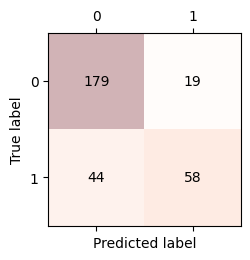

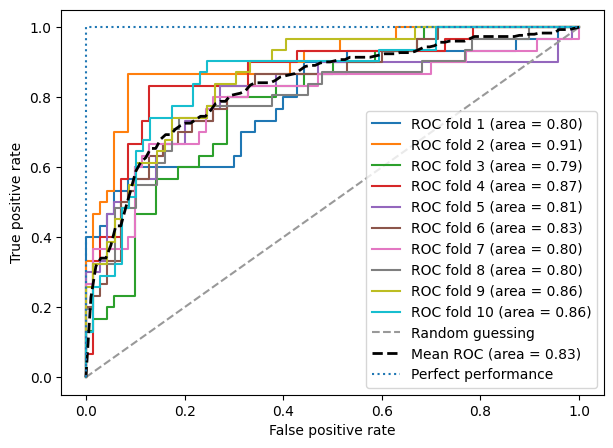

ROC auc score with accuracy 0.8536343830461478


In [235]:
confmat = confusion_matrix(y_true = y_test, y_pred = best_lr_acc.predict(X_test))
fig, ax = plt.subplots(figsize = (2.5,2.5))
ax.matshow(confmat, cmap = plt.cm.Reds, alpha =0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x= j, y= i, s= confmat[i,j], va = 'center', ha = 'center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

ROC_Curve(X_train, y_train, best_lr_acc)
print('ROC auc score with accuracy', roc_auc_score(y_true= y_test, y_score= best_lr_acc.predict_proba(X_test)[:,1]))


## F1 score

In [236]:
gs_lr_f1 = GridSearchCV(estimator= pipe_lr, param_grid= param_grid_lr, scoring= scorer_f1, refit= True, cv = 10, n_jobs= -1)
gs_lr_f1.fit(X_train, y_train)
best_lr_f1 = gs_lr_f1.best_estimator_
best_lr_f1.fit(X_train, y_train)
print(gs_lr_f1.best_params_)
#valuto lo score con la cross validation ossia lo score ottenuto sul validation dataset con quei valori degli iperparametri scelti.
scores = cross_val_score(estimator= best_lr_f1, X = X_train, y = y_train, cv =10, scoring= scorer_f1)
print('Cross validation f1_score: ', np.mean(scores), gs_lr_f1.best_score_)
print('F1 score del modello sul test data:', scorer_f1(best_lr_f1, X= X_test,y_true= y_test))
print('F1 score del modello sul train:', scorer_f1(best_lr_f1, X= X_train,y_true= y_train))



{'logisticregression__C': 10, 'logisticregression__max_iter': 100, 'logisticregression__solver': 'lbfgs'}
Cross validation f1_score:  0.8628946873212893 0.8628946873212893
F1 score del modello sul test data: 0.8503562945368172
F1 score del modello sul train: 0.8660774983004759


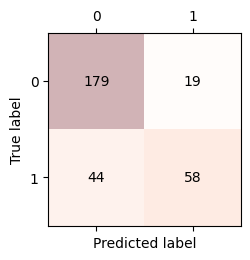

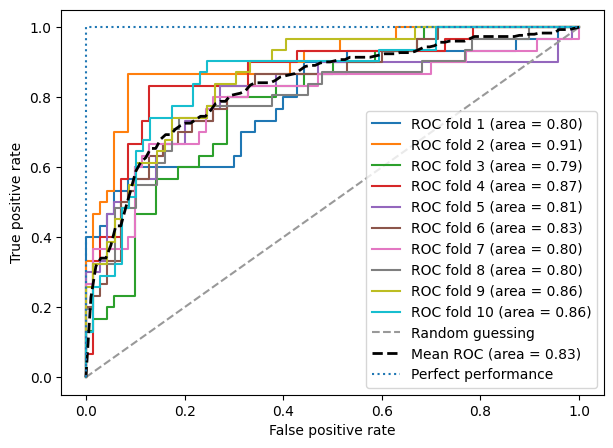

ROC auc score with f1 0.8536343830461478


In [237]:
confmat = confusion_matrix(y_true = y_test, y_pred = best_lr_f1.predict(X_test))
fig, ax = plt.subplots(figsize = (2.5,2.5))
ax.matshow(confmat, cmap = plt.cm.Reds, alpha =0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x= j, y= i, s= confmat[i,j], va = 'center', ha = 'center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

ROC_Curve(X_train, y_train, best_lr_f1)
print('ROC auc score with f1', roc_auc_score(y_true= y_test, y_score= best_lr_f1.predict_proba(X_test)[:,1]))


# Logistic regression + SBS (feature selection)


In [238]:

n_components = [5,6,7]
C_range = [0.1,1,10,100]
param_grid_lr_sbs = [{'logisticregression__C': C_range, 'logisticregression__max_iter':max_iter, 
'logisticregression__solver': ['lbfgs']}, 
{'logisticregression__C': C_range, 'logisticregression__max_iter':max_iter, 'logisticregression__solver': ['newton-cholesky']}]


## Accuracy

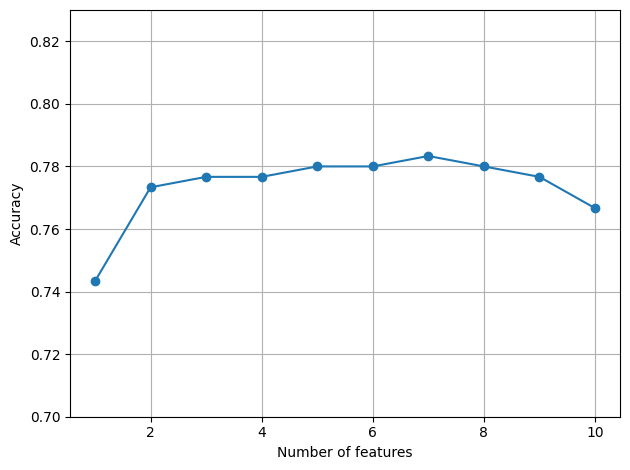

In [239]:
sbs = SBS(lr, k_features= 1)
sbs.fit(X_train, y_train)
k_feat  = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker = 'o')
plt.ylim([0.7,0.83])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.show()

In [240]:
sbs_7 = SBS(lr, k_features = 7)
pipe_lr_sbs_acc = make_pipeline(StandardScaler(), sbs_7, lr)
gs_lr_sbs_acc = GridSearchCV(estimator= pipe_lr_sbs_acc, param_grid = param_grid_lr_sbs, scoring = 'accuracy', cv  = 10, n_jobs= -1)
gs_lr_sbs_acc.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('sbs',
                                        <__main__.SBS object at 0x00000127E5668590>),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=500,
                                                           random_state=1))]),
             n_jobs=-1,
             param_grid=[{'logisticregression__C': [0.1, 1, 10, 100],
                          'logisticregression__max_iter': [100, 500, 1000],
                          'logisticregression__solver': ['lbfgs']},
                         {'logisticregression__C': [0.1, 1, 10, 100],
                          'logisticregression__max_iter': [100, 500, 1000],
                          'logisticregression__solver': ['newton-cholesky']}],
             scoring='accuracy')

In [241]:
best_lr_sbs_acc = gs_lr_sbs_acc.best_estimator_
best_lr_sbs_acc.fit(X_train, y_train)
print(gs_lr_sbs_acc.best_params_)
scores = cross_val_score(estimator= best_lr_sbs_acc, X = X_train, y = y_train, cv =10, n_jobs= -1)
print('Score valutato con la k-fold validation:', np.mean(scores), gs_lr_sbs_acc.best_score_)
print('Accuracy del modello valutato sul test data', best_lr_sbs_acc.score(X_test, y_test))
print('Accuracy del modello valutato sul train data', best_lr_sbs_acc.score(X_train, y_train))

{'logisticregression__C': 1, 'logisticregression__max_iter': 100, 'logisticregression__solver': 'lbfgs'}
Score valutato con la k-fold validation: 0.7729999999999999 0.7729999999999999
Accuracy del modello valutato sul test data 0.79
Accuracy del modello valutato sul train data 0.789


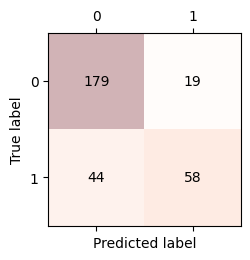

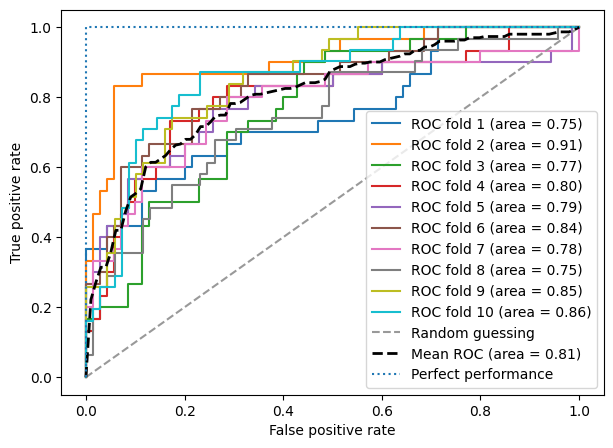

ROC auc score with accuracy 0.8561596355714003


In [242]:
confmat = confusion_matrix(y_true = y_test, y_pred = best_lr_sbs_acc.predict(X_test))
fig, ax = plt.subplots(figsize = (2.5,2.5))
ax.matshow(confmat, cmap = plt.cm.Reds, alpha =0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x= j, y= i, s= confmat[i,j], va = 'center', ha = 'center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

ROC_Curve(X_train, y_train, best_lr_sbs_acc)
print('ROC auc score with accuracy', roc_auc_score(y_true = y_test, y_score= best_lr_sbs_acc.predict_proba(X_test)[:,1]))

## F1 score

In [243]:
pipe_lr_sbs_f1 = make_pipeline(StandardScaler(), sbs_7, lr)
gs_lr_sbs_f1 = GridSearchCV(estimator= pipe_lr_sbs_f1, param_grid = param_grid_lr_sbs, scoring = scorer_f1, cv  = 10, n_jobs= -1)
gs_lr_sbs_f1.fit(X_train, y_train)
#forest.fit(X_train[:,k5], y_train)
best_lr_sbs_f1 = gs_lr_sbs_f1.best_estimator_
best_lr_sbs_f1.fit(X_train, y_train)
print(gs_lr_sbs_f1.best_params_)
scores = cross_val_score(estimator= best_lr_sbs_f1, X= X_train, y = y_train, cv = 10, scoring= scorer_f1)
print('CV accuracy:', np.mean(scores), gs_lr_sbs_f1.best_score_)
print('Accuracy on test data:', scorer_f1(best_lr_sbs_f1, X_test, y_test))
print('Accuracy on train data:', scorer_f1(best_lr_sbs_f1, X_train, y_train))

{'logisticregression__C': 0.1, 'logisticregression__max_iter': 100, 'logisticregression__solver': 'lbfgs'}
CV accuracy: 0.8523307801655925 0.8523307801655925
Accuracy on test data: 0.8524590163934426
Accuracy on train data: 0.85809906291834


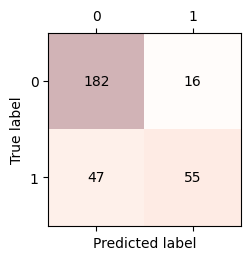

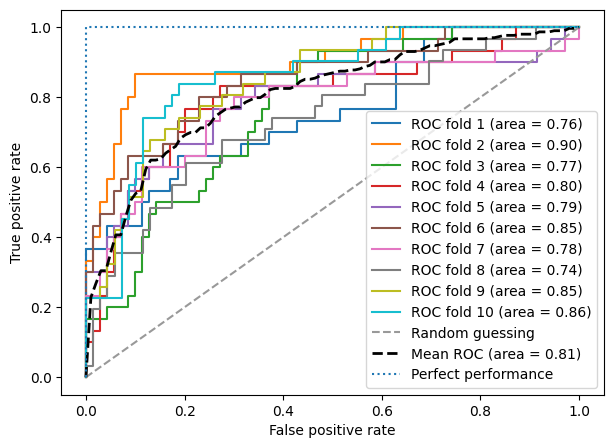

ROC auc score with accuracy 0.8595266389384035


In [244]:
confmat = confusion_matrix(y_true = y_test, y_pred = best_lr_sbs_f1.predict(X_test))
fig, ax = plt.subplots(figsize = (2.5,2.5))
ax.matshow(confmat, cmap = plt.cm.Reds, alpha =0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x= j, y= i, s= confmat[i,j], va = 'center', ha = 'center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

ROC_Curve(X_train, y_train, best_lr_sbs_f1)
print('ROC auc score with accuracy', roc_auc_score(y_true = y_test, y_score= best_lr_sbs_f1.predict_proba(X_test)[:,1]))

# Logistic regression + PCA

In [245]:
pca = PCA(n_components = None)
X_train_2, X_val, y_train_2, y_val = train_test_split(X_train_std, y_train, test_size= 0.3, random_state= 0 , stratify= y_train)
pca.fit(X_train_2)

PCA()

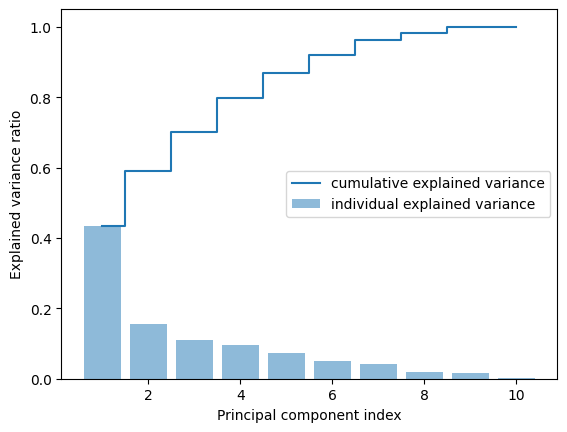

In [246]:
cum_var_exp = np.cumsum(pca.explained_variance_ratio_)
plt.bar(range(1,11), pca.explained_variance_ratio_, alpha  = 0.5, align = 'center', label = 'individual explained variance')
plt.step(range(1,11), cum_var_exp , where = 'mid', label = 'cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc = 'best')
plt.show()

In [247]:
n_components = [5,6,7]
pipe_lr_pca = make_pipeline(StandardScaler(), pca, lr)
param_grid_lr_pca = [{'logisticregression__C': C_range, 'logisticregression__max_iter': max_iter, 'pca__n_components': n_components, 'logisticregression__solver':['lbfgs']}, 
{'logisticregression__C': C_range, 'logisticregression__max_iter':max_iter, 
'pca__n_components': n_components, 'logisticregression__solver': ['newton-cholesky']}]

## Accuracy

In [248]:
gs_lr_pca_acc = GridSearchCV(estimator= pipe_lr_pca, param_grid= param_grid_lr_pca, cv = 10, scoring =  'accuracy', refit= True, n_jobs= -1)
gs_lr_pca_acc.fit(X_train, y_train)
best_lr_pca_acc = gs_lr_pca_acc.best_estimator_
best_lr_pca_acc.fit(X_train, y_train)
print(gs_lr_pca_acc.best_params_)
#valuto lo score con la cross validation ossia lo score ottenuto sul validation dataset con quei valori degli iperparametri scelti.
scores = cross_val_score(estimator= best_lr_pca_acc, X = X_train, y = y_train, cv =10)
print('Cross validation accuracy: ', np.mean(scores), gs_lr_pca_acc.best_score_)
print('Accuracy del modello sul test data:', best_lr_pca_acc.score(X_test, y_test))
print('Accuracy del modello sul train:', best_lr_pca_acc.score(X_train, y_train))

{'logisticregression__C': 10, 'logisticregression__max_iter': 100, 'logisticregression__solver': 'lbfgs', 'pca__n_components': 5}
Cross validation accuracy:  0.792 0.792
Accuracy del modello sul test data: 0.8033333333333333
Accuracy del modello sul train: 0.795


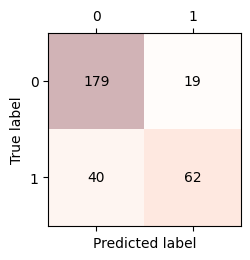

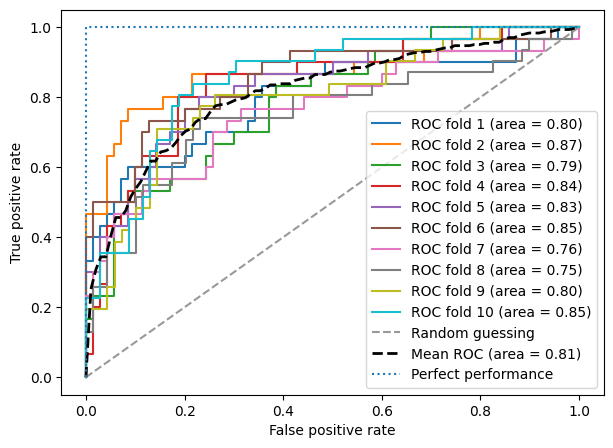

ROC auc score with accuracy 0.851059615765498


In [249]:
confmat = confusion_matrix(y_true = y_test, y_pred = best_lr_pca_acc.predict(X_test))
fig, ax = plt.subplots(figsize = (2.5,2.5))
ax.matshow(confmat, cmap = plt.cm.Reds, alpha =0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x= j, y= i, s= confmat[i,j], va = 'center', ha = 'center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

ROC_Curve(X_train, y_train, best_lr_pca_acc)
print('ROC auc score with accuracy', roc_auc_score(y_true= y_test, y_score= best_lr_pca_acc.predict_proba(X_test)[:,1]))

## F1 score

In [250]:
gs_lr_pca_f1 = GridSearchCV(estimator= pipe_lr_pca, param_grid= param_grid_lr_pca, cv= 10, scoring = scorer_f1, refit= True, n_jobs= -1)
gs_lr_pca_f1.fit(X_train, y_train)
best_lr_pca_f1 = gs_lr_pca_f1.best_estimator_
best_lr_pca_f1.fit(X_train, y_train)
print(gs_lr_pca_f1.best_params_)
#valuto lo score con la cross validation ossia lo score ottenuto sul validation dataset con quei valori degli iperparametri scelti.
scores = cross_val_score(estimator= best_lr_pca_f1, X = X_train, y = y_train, cv =10, scoring= scorer_f1)
print('Cross validation accuracy: ', np.mean(scores), gs_lr_pca_f1.best_score_)
print('F1 score del modello sul test data', scorer_f1(best_lr_pca_f1, X = X_test,y_true= y_test))
print('F1 score del modello sul train data', scorer_f1(best_lr_pca_f1, X = X_train, y_true= y_train))


{'logisticregression__C': 10, 'logisticregression__max_iter': 100, 'logisticregression__solver': 'lbfgs', 'pca__n_components': 5}
Cross validation accuracy:  0.8598292382362853 0.8598292382362853
F1 score del modello sul test data 0.8585131894484412
F1 score del modello sul train data 0.8613928329952671


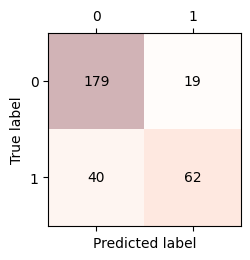

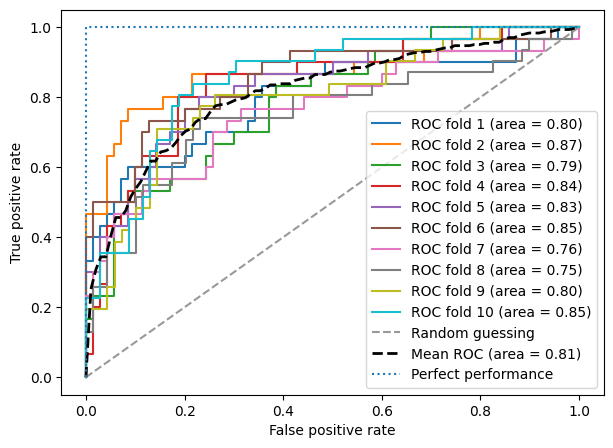

ROC auc score with f1 0.851059615765498


In [251]:
confmat = confusion_matrix(y_true = y_test, y_pred = best_lr_pca_f1.predict(X_test))
fig, ax = plt.subplots(figsize = (2.5,2.5))
ax.matshow(confmat, cmap = plt.cm.Reds, alpha =0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x= j, y= i, s= confmat[i,j], va = 'center', ha = 'center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

ROC_Curve(X_train, y_train, best_lr_pca_f1)
print('ROC auc score with f1', roc_auc_score(y_true= y_test, y_score= best_lr_pca_f1.predict_proba(X_test)[:,1]))


# Logistic regression + KPCA

In [252]:
kpca = KernelPCA(kernel= 'rbf')
pipe_lr_kpca = make_pipeline(StandardScaler(),kpca, lr)
param_grid_lr_kpca = [{'kernelpca__n_components': n_components, 'logisticregression__C':C_range, 'logisticregression__max_iter':max_iter, 'logisticregression__solver':['lbfgs']}, 
{'logisticregression__C': C_range, 'logisticregression__max_iter':max_iter, 
'kernelpca__n_components': n_components, 'logisticregression__solver': ['newton-cholesky']}]

## Accuracy

In [253]:
gs_lr_kpca_acc = GridSearchCV(estimator= pipe_lr_kpca, param_grid= param_grid_lr_kpca, cv = 10, scoring= 'accuracy', n_jobs= -1)
gs_lr_kpca_acc.fit(X_train, y_train)
best_lr_kpca_acc = gs_lr_kpca_acc.best_estimator_
best_lr_kpca_acc.fit(X_train, y_train)
print(gs_lr_kpca_acc.best_params_)
scores = cross_val_score(estimator= best_lr_kpca_acc, X= X_train, y = y_train, cv = 10)
print('CV accuracy:', np.mean(scores), gs_lr_kpca_acc.best_score_)
print('Accuracy on test data:', best_lr_kpca_acc.score(X_test, y_test))
print('Accuracy on train data:', best_lr_kpca_acc.score(X_train, y_train))

{'kernelpca__n_components': 7, 'logisticregression__C': 1, 'logisticregression__max_iter': 100, 'logisticregression__solver': 'lbfgs'}
CV accuracy: 0.799 0.799
Accuracy on test data: 0.8066666666666666
Accuracy on train data: 0.805


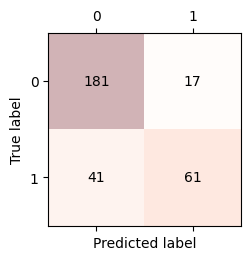

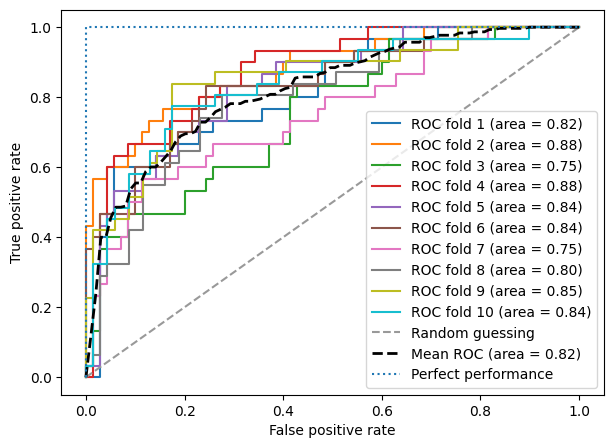

ROC auc score with accuracy 0.8587344028520499


In [254]:
confmat = confusion_matrix(y_true = y_test, y_pred = best_lr_kpca_acc.predict(X_test))
fig, ax = plt.subplots(figsize = (2.5,2.5))
ax.matshow(confmat, cmap = plt.cm.Reds, alpha =0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x= j, y= i, s= confmat[i,j], va = 'center', ha = 'center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

ROC_Curve(X_train, y_train, best_lr_kpca_acc)
print('ROC auc score with accuracy', roc_auc_score(y_true= y_test, y_score= best_lr_kpca_acc.predict_proba(X_test)[:,1]))

## F1 score

In [255]:
gs_lr_kpca_f1 = GridSearchCV(estimator= pipe_lr_kpca, param_grid= param_grid_lr_kpca, cv = 10, scoring= scorer_f1, n_jobs= -1)
gs_lr_kpca_f1.fit(X_train, y_train)
best_lr_kpca_f1 = gs_lr_kpca_f1.best_estimator_
best_lr_kpca_f1.fit(X_train, y_train)
print(gs_lr_kpca_f1.best_params_)
scores = cross_val_score(estimator= best_lr_kpca_f1, X= X_train, y = y_train, cv = 10, scoring= scorer_f1)
print('CV accuracy:', np.mean(scores), gs_lr_kpca_f1.best_score_)
print('Accuracy on test data:', scorer_f1(best_lr_kpca_f1, X_test, y_test))
print('Accuracy on train data:', scorer_f1(best_lr_kpca_f1, X_train, y_train))

{'kernelpca__n_components': 7, 'logisticregression__C': 1, 'logisticregression__max_iter': 100, 'logisticregression__solver': 'lbfgs'}
CV accuracy: 0.8649553256862612 0.8649553256862612
Accuracy on test data: 0.8619047619047618
Accuracy on train data: 0.8681541582150103


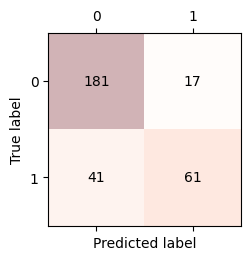

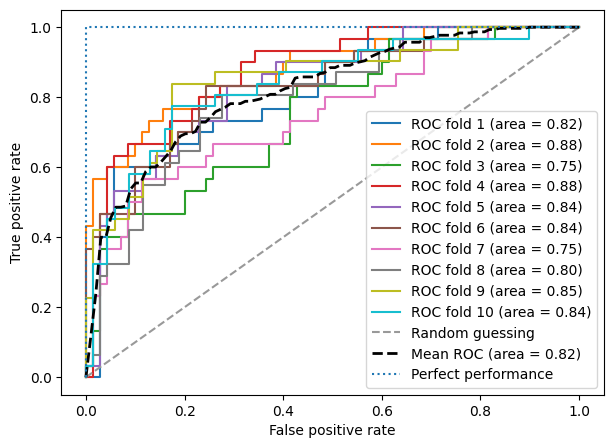

ROC auc score with accuracy 0.8587344028520499


In [256]:
confmat = confusion_matrix(y_true = y_test, y_pred = best_lr_kpca_f1.predict(X_test))
fig, ax = plt.subplots(figsize = (2.5,2.5))
ax.matshow(confmat, cmap = plt.cm.Reds, alpha =0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x= j, y= i, s= confmat[i,j], va = 'center', ha = 'center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

ROC_Curve(X_train, y_train, best_lr_kpca_f1)
print('ROC auc score with accuracy', roc_auc_score(y_true= y_test, y_score= best_lr_kpca_f1.predict_proba(X_test)[:,1]))


# Random Forest

In [257]:
forest = RandomForestClassifier(random_state= 1)
pipe_rfc = make_pipeline(forest)
max_depth = [100,500,800]
n_trees = [100,400,1000]
param_grid_rfc = [{'randomforestclassifier__n_estimators': n_trees, 'randomforestclassifier__max_depth': max_depth, 'randomforestclassifier__criterion':['gini']}, 
{'randomforestclassifier__n_estimators': n_trees, 'randomforestclassifier__max_depth': max_depth, 'randomforestclassifier__criterion':['entropy']}]


## Accuracy

In [258]:
gs_rfc_acc = GridSearchCV(estimator= pipe_rfc, param_grid = param_grid_rfc, scoring = 'accuracy', refit = True, cv  = 10, n_jobs= -1)
gs_rfc_acc.fit(X_train, y_train)
best_rfc_acc = gs_rfc_acc.best_estimator_
best_rfc_acc.fit(X_train, y_train)
print(gs_rfc_acc.best_params_)
scores = cross_val_score(estimator= best_rfc_acc, X = X_train, y = y_train, cv =10)
print('Score valutato con la k-fold validation:', np.mean(scores), gs_rfc_acc.best_score_)
print('Accuracy del modello valutato sul test data', best_rfc_acc.score(X_test, y_test))
print('Accuracy del modello valutato sul train data', best_rfc_acc.score(X_train, y_train))



{'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 100, 'randomforestclassifier__n_estimators': 400}
Score valutato con la k-fold validation: 0.8470000000000001 0.8470000000000001
Accuracy del modello valutato sul test data 0.87
Accuracy del modello valutato sul train data 1.0


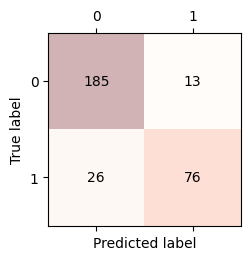

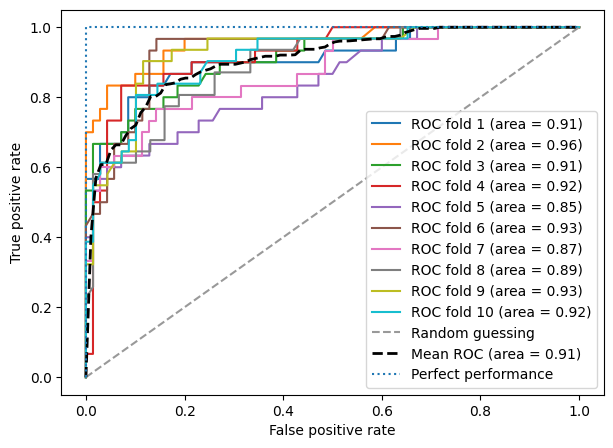

ROC auc score with accuracy 0.9328332343038226


In [259]:
confmat = confusion_matrix(y_true = y_test, y_pred = best_rfc_acc.predict(X_test))
fig, ax = plt.subplots(figsize = (2.5,2.5))
ax.matshow(confmat, cmap = plt.cm.Reds, alpha =0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x= j, y= i, s= confmat[i,j], va = 'center', ha = 'center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

ROC_Curve(X_train, y_train, best_rfc_acc)
print('ROC auc score with accuracy', roc_auc_score(y_true=  y_test, y_score= best_rfc_acc.predict_proba(X_test)[:,1]))

## F1 Score


In [260]:
gs_rfc_f1 = GridSearchCV(estimator= pipe_rfc, param_grid= param_grid_rfc, cv = 10, scoring= scorer_f1, n_jobs= -1)
gs_rfc_f1.fit(X_train, y_train)
best_rfc_f1 = gs_rfc_f1.best_estimator_
best_rfc_f1.fit(X_train, y_train)
print(gs_rfc_f1.best_params_)
scores = cross_val_score(estimator= best_rfc_f1, X= X_train, y = y_train, cv = 10, scoring= scorer_f1)
print('CV accuracy:', np.mean(scores), gs_rfc_f1.best_score_)
print('Accuracy on test data:', scorer_f1(best_rfc_f1, X_test, y_test))
print('Accuracy on train data:', scorer_f1(best_rfc_f1, X_train, y_train))

{'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 100, 'randomforestclassifier__n_estimators': 400}
CV accuracy: 0.89498820469415 0.89498820469415
Accuracy on test data: 0.9046454767726161
Accuracy on train data: 1.0


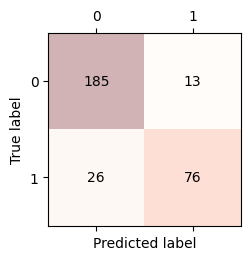

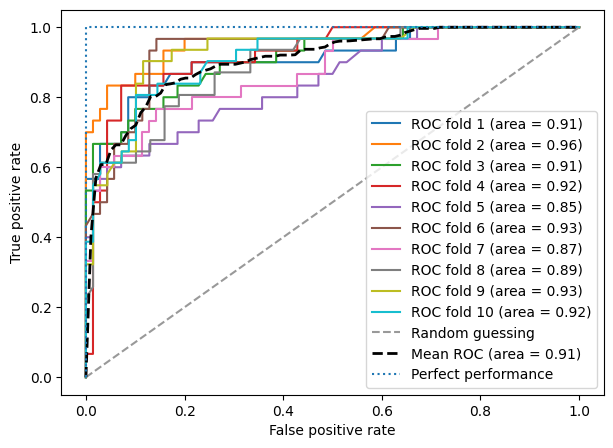

ROC auc score with accuracy 0.9328332343038226


In [261]:
confmat = confusion_matrix(y_true = y_test, y_pred = best_rfc_f1.predict(X_test))
fig, ax = plt.subplots(figsize = (2.5,2.5))
ax.matshow(confmat, cmap = plt.cm.Reds, alpha =0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x= j, y= i, s= confmat[i,j], va = 'center', ha = 'center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

ROC_Curve(X_train, y_train, best_rfc_f1)
print('ROC auc score with accuracy', roc_auc_score(y_true = y_test, y_score= best_rfc_f1.predict_proba(X_test)[:,1]))


# Random forest + pca


In [262]:
n_trees = [100, 400]
max_depth=[100,300]
n_components=[5,6,7]
pipe_rfc_pca = make_pipeline(StandardScaler(), pca, forest)
param_grid_rfc_pca = [{'randomforestclassifier__n_estimators': n_trees, 'randomforestclassifier__max_depth': max_depth, 
'randomforestclassifier__criterion':['gini'], 'pca__n_components': n_components}, 
{'randomforestclassifier__n_estimators': n_trees, 'randomforestclassifier__max_depth': max_depth, 'randomforestclassifier__criterion':['entropy'], 
'pca__n_components':n_components}]


## Accuracy


In [263]:
gs_rfc_pca_acc = GridSearchCV(estimator= pipe_rfc_pca, param_grid = param_grid_rfc_pca, scoring = 'accuracy',cv  = 10, n_jobs= -1)
gs_rfc_pca_acc.fit(X_train, y_train)
best_rfc_pca_acc = gs_rfc_pca_acc.best_estimator_
best_rfc_pca_acc.fit(X_train, y_train)
print(gs_rfc_pca_acc.best_params_)
scores = cross_val_score(estimator= best_rfc_pca_acc, X = X_train, y = y_train, cv =10)
print('Score valutato con la k-fold validation:', np.mean(scores), gs_rfc_pca_acc.best_score_)
print('Accuracy del modello valutato sul test data', best_rfc_pca_acc.score(X_test, y_test))
print('Accuracy del modello valutato sul train data', best_rfc_pca_acc.score(X_train, y_train))

{'pca__n_components': 7, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 100, 'randomforestclassifier__n_estimators': 400}
Score valutato con la k-fold validation: 0.806 0.806
Accuracy del modello valutato sul test data 0.8333333333333334
Accuracy del modello valutato sul train data 1.0


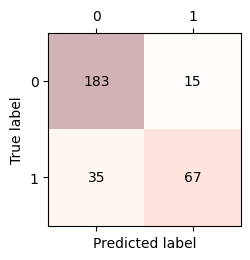

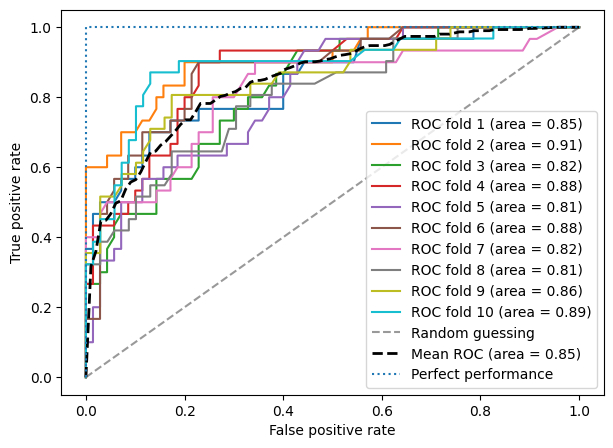

ROC auc score with accuracy 0.8748514557338087


In [264]:
confmat = confusion_matrix(y_true = y_test, y_pred = best_rfc_pca_acc.predict(X_test))
fig, ax = plt.subplots(figsize = (2.5,2.5))
ax.matshow(confmat, cmap = plt.cm.Reds, alpha =0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x= j, y= i, s= confmat[i,j], va = 'center', ha = 'center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

ROC_Curve(X_train, y_train, best_rfc_pca_acc)
print('ROC auc score with accuracy', roc_auc_score(y_true= y_test, y_score= best_rfc_pca_acc.predict_proba(X_test)[:,1]))

## F1 score

In [265]:
gs_rfc_pca_f1 = GridSearchCV(estimator= pipe_rfc_pca, param_grid= param_grid_rfc_pca, cv = 10, scoring= scorer_f1, n_jobs= -1)
gs_rfc_pca_f1.fit(X_train, y_train)
best_rfc_pca_f1 = gs_rfc_pca_f1.best_estimator_
best_rfc_pca_f1.fit(X_train, y_train)
print(gs_rfc_pca_f1.best_params_)
scores = cross_val_score(estimator= best_rfc_pca_f1, X= X_train, y = y_train, cv = 10, scoring= scorer_f1)
print('CV accuracy:', np.mean(scores), gs_rfc_pca_f1.best_score_)
print('Accuracy on test data:', scorer_f1(best_rfc_pca_f1, X_test, y_test))
print('Accuracy on train data:', scorer_f1(best_rfc_pca_f1, X_train, y_train))

{'pca__n_components': 7, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 100, 'randomforestclassifier__n_estimators': 400}
CV accuracy: 0.869695948170167 0.869695948170167
Accuracy on test data: 0.8798076923076922
Accuracy on train data: 1.0


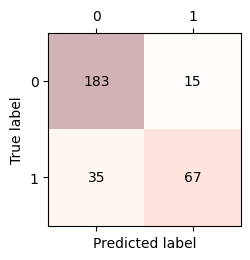

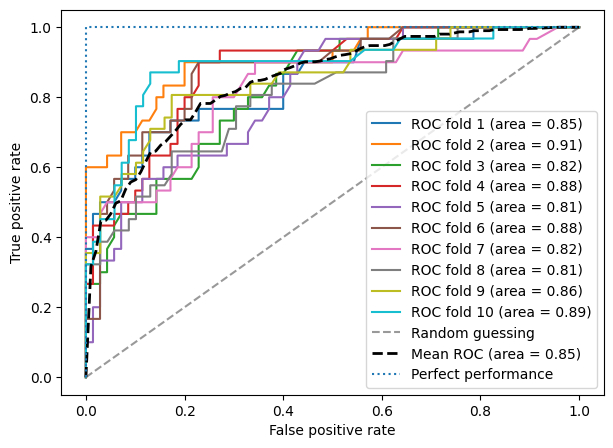

ROC auc score with accuracy 0.8748514557338087


In [266]:
confmat = confusion_matrix(y_true = y_test, y_pred = best_rfc_pca_f1.predict(X_test))
fig, ax = plt.subplots(figsize = (2.5,2.5))
ax.matshow(confmat, cmap = plt.cm.Reds, alpha =0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x= j, y= i, s= confmat[i,j], va = 'center', ha = 'center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

ROC_Curve(X_train, y_train, best_rfc_pca_f1)
print('ROC auc score with accuracy', roc_auc_score(y_true = y_test, y_score= best_rfc_pca_f1.predict_proba(X_test)[:,1]))

# Random Forest + Feature selection

In [267]:
n_trees = [100, 400]
max_depth=[100,300]
n_components=[5,6,7]
#forest_sbs = RandomForestClassifier(random_state =1)
#sbs = SequentialFeatureSelector(estimator = forest, scoring = 'accuracy', cv = 10, n_features_to_select= 6)
#pipe_rfc_sbs
# ù = make_pipeline(StandardScaler(), forest)
param_grid_rfc_sbs = [{'randomforestclassifier__n_estimators': n_trees, 'randomforestclassifier__max_depth': max_depth, 'randomforestclassifier__criterion':['gini']}, 
{'randomforestclassifier__n_estimators': n_trees, 'randomforestclassifier__max_depth': max_depth, 'randomforestclassifier__criterion':['entropy']}]


## Accuracy


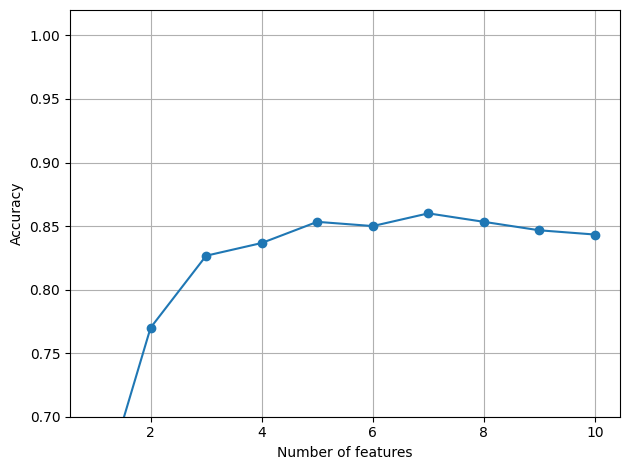

In [268]:
sbs = SBS(forest, k_features= 1)
sbs.fit(X_train, y_train)
k_feat  = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker = 'o')
plt.ylim([0.7,1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.show()

In [269]:
sbs_5 = SBS(forest, k_features = 5)
pipe_rfc_sbs_acc = make_pipeline(StandardScaler(), sbs_5, forest)
gs_rfc_sbs_acc = GridSearchCV(estimator= pipe_rfc_sbs_acc, param_grid = param_grid_rfc_sbs, scoring = 'accuracy', cv  = 10, n_jobs= -1)
gs_rfc_sbs_acc.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('sbs',
                                        <__main__.SBS object at 0x00000127F0314810>),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=1))]),
             n_jobs=-1,
             param_grid=[{'randomforestclassifier__criterion': ['gini'],
                          'randomforestclassifier__max_depth': [100, 300],
                          'randomforestclassifier__n_estimators': [100, 400]},
                         {'randomforestclassifier__criterion': ['entropy'],
                          'randomforestclassifier__max_depth': [100, 300],
                          'randomforestclassifier__n_estimators': [100, 400]}],
             scoring='accuracy')

In [270]:
best_rfc_sbs_acc = gs_rfc_sbs_acc.best_estimator_
best_rfc_sbs_acc.fit(X_train, y_train)
print(gs_rfc_sbs_acc.best_params_)
scores = cross_val_score(estimator= best_rfc_sbs_acc, X = X_train, y = y_train, cv =10, n_jobs= -1)
print('Score valutato con la k-fold validation:', np.mean(scores), gs_rfc_sbs_acc.best_score_)
print('Accuracy del modello valutato sul test data', best_rfc_sbs_acc.score(X_test, y_test))
print('Accuracy del modello valutato sul train data', best_rfc_sbs_acc.score(X_train, y_train))

{'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 100, 'randomforestclassifier__n_estimators': 400}
Score valutato con la k-fold validation: 0.8370000000000001 0.8370000000000001
Accuracy del modello valutato sul test data 0.8333333333333334
Accuracy del modello valutato sul train data 1.0


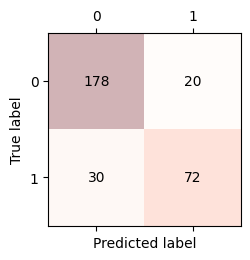

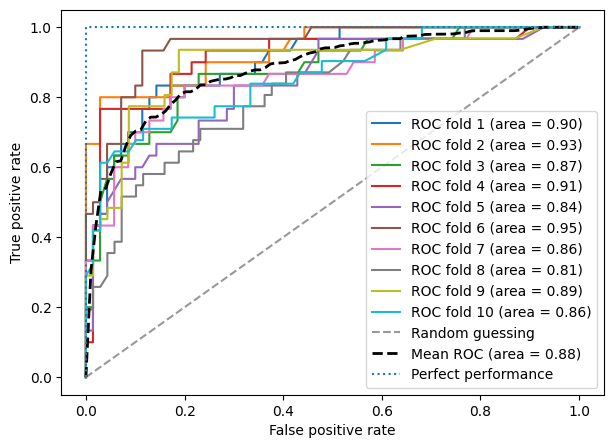

ROC auc score with accuracy 0.9015894236482471


In [271]:
confmat = confusion_matrix(y_true = y_test, y_pred = best_rfc_sbs_acc.predict(X_test))
fig, ax = plt.subplots(figsize = (2.5,2.5))
ax.matshow(confmat, cmap = plt.cm.Reds, alpha =0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x= j, y= i, s= confmat[i,j], va = 'center', ha = 'center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

ROC_Curve(X_train, y_train, best_rfc_sbs_acc)
print('ROC auc score with accuracy', roc_auc_score(y_true = y_test, y_score= best_rfc_sbs_acc.predict_proba(X_test)[:,1]))

## F1 score

In [272]:
pipe_rfc_sbs_f1 = make_pipeline(StandardScaler(), sbs_5, forest)
gs_rfc_sbs_f1 = GridSearchCV(estimator= pipe_rfc_sbs_f1, param_grid = param_grid_rfc_sbs, scoring = scorer_f1, cv  = 10, n_jobs= -1)
gs_rfc_sbs_f1.fit(X_train, y_train)
#forest.fit(X_train[:,k5], y_train)
best_rfc_sbs_f1 = gs_rfc_sbs_f1.best_estimator_
best_rfc_sbs_f1.fit(X_train, y_train)
print(gs_rfc_sbs_f1.best_params_)
scores = cross_val_score(estimator= best_rfc_sbs_f1, X= X_train, y = y_train, cv = 10, scoring= scorer_f1)
print('CV accuracy:', np.mean(scores), gs_rfc_sbs_f1.best_score_)
print('Accuracy on test data:', scorer_f1(best_rfc_sbs_f1, X_test, y_test))
print('Accuracy on train data:', scorer_f1(best_rfc_sbs_f1, X_train, y_train))

{'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 100, 'randomforestclassifier__n_estimators': 400}
CV accuracy: 0.8886632024871162 0.8886632024871162
Accuracy on test data: 0.8768472906403941
Accuracy on train data: 1.0


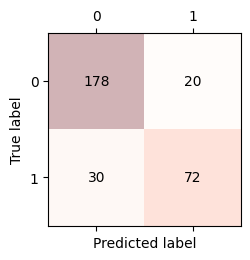

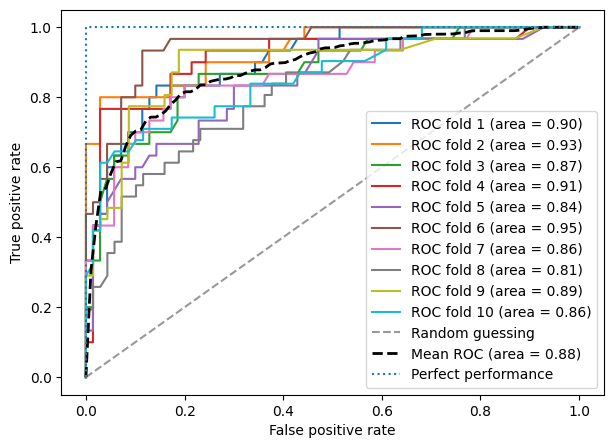

ROC auc score with accuracy 0.9015894236482471


In [273]:
confmat = confusion_matrix(y_true = y_test, y_pred = best_rfc_sbs_f1.predict(X_test))
fig, ax = plt.subplots(figsize = (2.5,2.5))
ax.matshow(confmat, cmap = plt.cm.Reds, alpha =0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x= j, y= i, s= confmat[i,j], va = 'center', ha = 'center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

ROC_Curve(X_train, y_train, best_rfc_sbs_f1)
print('ROC auc score with accuracy', roc_auc_score(y_true = y_test, y_score= best_rfc_sbs_f1.predict_proba(X_test)[:,1]))

# Random forest + KPCA


In [274]:
kpca = KernelPCA(kernel= 'rbf')
#param_range = [0.01, 0.1, 1,5,10,15,20,25,30,35]
pipe_rfc_kpca = make_pipeline(StandardScaler(),kpca, forest)
param_grid_rfc_kpca = [{'randomforestclassifier__n_estimators': n_trees, 'randomforestclassifier__max_depth': max_depth, 
'randomforestclassifier__criterion':['gini'], 'kernelpca__n_components': n_components},
{'randomforestclassifier__n_estimators': n_trees, 'randomforestclassifier__max_depth': max_depth, 
'randomforestclassifier__criterion':['entropy'], 'kernelpca__n_components': n_components}]


## Accuracy

In [275]:
gs_rfc_kpca_acc = GridSearchCV(estimator= pipe_rfc_kpca, param_grid= param_grid_rfc_kpca, cv = 10, scoring= 'accuracy', n_jobs= -1)
gs_rfc_kpca_acc.fit(X_train, y_train)
best_rfc_kpca_acc = gs_rfc_kpca_acc.best_estimator_
best_rfc_kpca_acc.fit(X_train, y_train)
scores = cross_val_score(estimator= best_rfc_kpca_acc, X = X_train, y = y_train, cv = 10)
print('Score valutato con la k-fold validation:', np.mean(scores), gs_rfc_kpca_acc.best_score_)
print('Accuracy del modello sul test data:', best_rfc_kpca_acc.score(X_test, y_test))
print('Accuracy del modello sul train data:', best_rfc_kpca_acc.score(X_train, y_train))

Score valutato con la k-fold validation: 0.812 0.812
Accuracy del modello sul test data: 0.8066666666666666
Accuracy del modello sul train data: 1.0


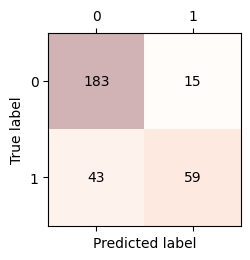

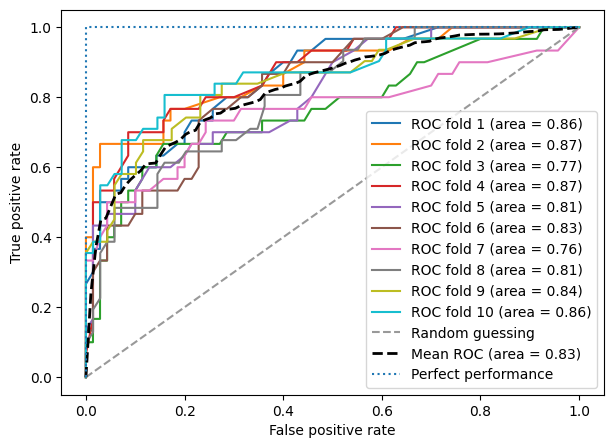

ROC auc score with accuracy 0.847172707466825


In [276]:
confmat = confusion_matrix(y_true = y_test, y_pred = best_rfc_kpca_acc.predict(X_test))
fig, ax = plt.subplots(figsize = (2.5,2.5))
ax.matshow(confmat, cmap = plt.cm.Reds, alpha =0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x= j, y= i, s= confmat[i,j], va = 'center', ha = 'center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

ROC_Curve(X_train, y_train, best_rfc_kpca_acc)
print('ROC auc score with accuracy', roc_auc_score(y_true = y_test, y_score= best_rfc_kpca_acc.predict_proba(X_test)[:,1]))


## F1 score

In [277]:
gs_rfc_kpca_f1 = GridSearchCV(estimator= pipe_rfc_kpca, param_grid= param_grid_rfc_kpca, cv = 10, scoring= scorer_f1, n_jobs= -1)
gs_rfc_kpca_f1.fit(X_train, y_train)
best_rfc_kpca_f1 = gs_rfc_kpca_f1.best_estimator_
best_rfc_kpca_f1.fit(X_train, y_train)
print(gs_rfc_kpca_f1.best_params_)
scores = cross_val_score(estimator= best_rfc_kpca_f1, X= X_train, y = y_train, cv = 10, scoring= scorer_f1)
print('CV accuracy:', np.mean(scores), gs_rfc_kpca_f1.best_score_)
print('Accuracy on test data:', scorer_f1(best_rfc_kpca_f1, X_test, y_test))
print('Accuracy on train data:', scorer_f1(best_rfc_kpca_f1, X_train, y_train))

{'kernelpca__n_components': 5, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 100, 'randomforestclassifier__n_estimators': 100}
CV accuracy: 0.8732610735963682 0.8732610735963682
Accuracy on test data: 0.8632075471698114
Accuracy on train data: 1.0


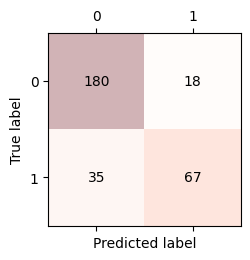

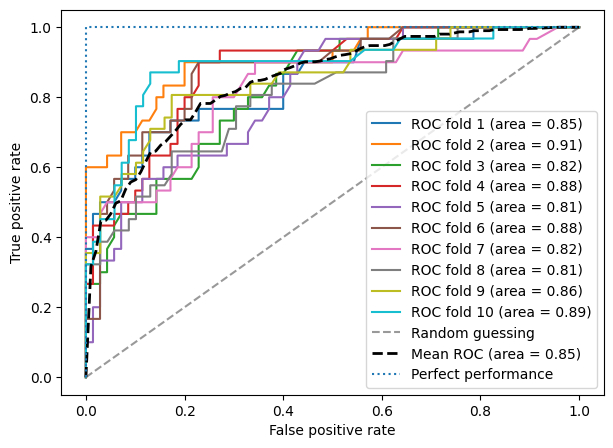

ROC auc score with accuracy 0.8748514557338087


In [278]:
confmat = confusion_matrix(y_true = y_test, y_pred = best_rfc_pca_f1.predict(X_test))
fig, ax = plt.subplots(figsize = (2.5,2.5))
ax.matshow(confmat, cmap = plt.cm.Reds, alpha =0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x= j, y= i, s= confmat[i,j], va = 'center', ha = 'center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

ROC_Curve(X_train, y_train, best_rfc_pca_f1)
print('ROC auc score with accuracy', roc_auc_score(y_true = y_test, y_score= best_rfc_pca_f1.predict_proba(X_test)[:,1]))

# Migliori classificatori


In [279]:
lr_1 = best_lr_acc
print("lr_1",lr_1)
scores = cross_val_score(estimator= best_lr_acc, X = X_train, y = y_train, cv =10)
print('Cross validation accuracy: ', np.mean(scores), gs_lr_acc.best_score_)
print('Accuracy del modello sul test data:', best_lr_acc.score(X_test, y_test))
print('Accuracy del modello sul train:', best_lr_acc.score(X_train, y_train))
print('ROC auc score with accuracy', roc_auc_score(y_true = y_test, y_score= lr_1.predict_proba(X_test)[:,1]))
print('-------------')
lr_2 = best_lr_f1
print("lr_2",lr_2)
scores = cross_val_score(estimator= best_lr_f1, X = X_train, y = y_train, cv =10, scoring= scorer_f1)
print('Cross validation f1_score: ', np.mean(scores), gs_lr_f1.best_score_)
print('F1 score del modello sul test data:', scorer_f1(best_lr_f1, X= X_test,y_true= y_test))
print('F1 score del modello sul train:', scorer_f1(best_lr_f1, X= X_train,y_true= y_train))
print('ROC auc score with accuracy', roc_auc_score(y_true = y_test, y_score= lr_2.predict_proba(X_test)[:,1]))
print('-------------')
lr_sbs_1 = best_lr_sbs_acc
print("lr_sbs_1",lr_sbs_1)
scores = cross_val_score(estimator= best_lr_sbs_acc, X = X_train, y = y_train, cv = 10)
print('CV accuracy score:', np.mean(scores), gs_lr_sbs_acc.best_score_)
print('Accuracy sul test data:',best_lr_sbs_acc.score(X_test, y_test))
print('Accuracy sul train data:', best_lr_sbs_acc.score(X_train, y_train))
print('ROC auc score with accuracy', roc_auc_score(y_true = y_test, y_score= lr_sbs_1.predict_proba(X_test)[:,1]))
print('-------------')
lr_sbs_2 = best_lr_sbs_f1
print("lr_sbs_2",lr_sbs_2)
scores = cross_val_score(estimator= best_lr_sbs_f1, X = X_train, y = y_train, cv =10, scoring= scorer_f1)
print('Cross validation f1_score: ', np.mean(scores), gs_lr_sbs_f1.best_score_)
print('F1 score del modello sul test data:', scorer_f1(best_lr_sbs_f1, X= X_test,y_true= y_test))
print('F1 score del modello sul train:', scorer_f1(best_lr_sbs_f1, X= X_train,y_true= y_train))
print('ROC auc score with accuracy', roc_auc_score(y_true = y_test, y_score= lr_sbs_2.predict_proba(X_test)[:,1]))
print('-------------')
lr_pca_1 = best_lr_pca_acc
print("lr_pca_1",lr_pca_1)
scores = cross_val_score(estimator= best_lr_pca_acc, X = X_train, y = y_train, cv =10)
print('Cross validation accuracy: ', np.mean(scores), gs_lr_pca_acc.best_score_)
print('Accuracy del modello sul test data:', best_lr_pca_acc.score(X_test, y_test))
print('Accuracy del modello sul train:', best_lr_pca_acc.score(X_train, y_train))
print('ROC auc score with accuracy', roc_auc_score(y_true = y_test, y_score= lr_pca_1.predict_proba(X_test)[:,1]))
print('-------------')
lr_pca_2 = best_lr_pca_f1
print("lr_pca_2",lr_pca_2)
scores = cross_val_score(estimator= best_lr_pca_f1, X = X_train, y = y_train, cv =10, scoring= scorer_f1)
print('Cross validation accuracy: ', np.mean(scores), gs_lr_pca_f1.best_score_)
print('F1 score del modello sul test data', scorer_f1(best_lr_pca_f1, X = X_test,y_true= y_test))
print('F1 score del modello sul train data', scorer_f1(best_lr_pca_f1, X = X_train, y_true= y_train))
print('ROC auc score with accuracy', roc_auc_score(y_true = y_test, y_score= lr_pca_2.predict_proba(X_test)[:,1]))
print('-------------')
lr_kpca_1 = best_lr_kpca_acc
print("lr_kpca_1",lr_kpca_1)
scores = cross_val_score(estimator= best_lr_kpca_acc, X= X_train, y = y_train, cv = 10)
print('CV accuracy:', np.mean(scores), gs_lr_kpca_acc.best_score_)
print('Accuracy on test data:', best_lr_kpca_acc.score(X_test, y_test))
print('Accuracy on train data:', best_lr_kpca_acc.score(X_train, y_train))
print('ROC auc score with accuracy', roc_auc_score(y_true = y_test, y_score= lr_kpca_1.predict_proba(X_test)[:,1]))
print('-------------')
lr_kpca_2 = best_lr_kpca_f1
print("lr_kpca_2",lr_kpca_2)
scores = cross_val_score(estimator= best_lr_kpca_f1, X= X_train, y = y_train, cv = 10, scoring= scorer_f1)
print('CV accuracy:', np.mean(scores), gs_lr_kpca_f1.best_score_)
print('Accuracy on test data:', scorer_f1(best_lr_kpca_f1, X_test, y_test))
print('Accuracy on train data:', scorer_f1(best_lr_kpca_f1, X_train, y_train))
print('ROC auc score with accuracy', roc_auc_score(y_true = y_test, y_score= lr_kpca_2.predict_proba(X_test)[:,1]))
print('-------------')
rfc_1 = best_rfc_acc
print("rfc_1",rfc_1)
scores = cross_val_score(estimator= best_rfc_acc, X = X_train, y = y_train, cv =10)
print('Score valutato con la k-fold validation:', np.mean(scores), gs_rfc_acc.best_score_)
print('Accuracy del modello valutato sul test data', best_rfc_acc.score(X_test, y_test))
print('Accuracy del modello valutato sul train data', best_rfc_acc.score(X_train, y_train))
print('ROC auc score with accuracy', roc_auc_score(y_true = y_test, y_score= rfc_1.predict_proba(X_test)[:,1]))
print('-------------')
rfc_2 = best_rfc_f1
print("rfc_2",rfc_2)
scores = cross_val_score(estimator= best_rfc_f1, X= X_train, y = y_train, cv = 10, scoring= scorer_f1)
print('CV accuracy:', np.mean(scores), gs_rfc_f1.best_score_)
print('Accuracy on test data:', scorer_f1(best_rfc_f1, X_test, y_test))
print('Accuracy on train data:', scorer_f1(best_rfc_f1, X_train, y_train))
print('ROC auc score with accuracy', roc_auc_score(y_true = y_test, y_score= rfc_2.predict_proba(X_test)[:,1]))
print('-------------')
rfc_sbs_1 = best_rfc_sbs_acc
print("rfc_sbs_1",rfc_sbs_1)
scores = cross_val_score(estimator= best_rfc_sbs_acc, X = X_train, y = y_train, cv =10, n_jobs= -1)
print('Score valutato con la k-fold validation:', np.mean(scores), gs_rfc_sbs_acc.best_score_)
print('Accuracy del modello valutato sul test data', best_rfc_sbs_acc.score(X_test, y_test))
print('Accuracy del modello valutato sul train data', best_rfc_sbs_acc.score(X_train, y_train))
print('ROC auc score with accuracy', roc_auc_score(y_true = y_test, y_score= rfc_sbs_1.predict_proba(X_test)[:,1]))
print('-------------')
rfc_sbs_2 = best_rfc_sbs_f1
print("rfc_sbs_2",rfc_sbs_2)
scores = cross_val_score(estimator= best_rfc_sbs_f1, X= X_train, y = y_train, cv = 10, scoring= scorer_f1)
print('CV accuracy:', np.mean(scores), gs_rfc_sbs_f1.best_score_)
print('Accuracy on test data:', scorer_f1(best_rfc_sbs_f1, X_test, y_test))
print('Accuracy on train data:', scorer_f1(best_rfc_sbs_f1, X_train, y_train))
print('ROC auc score with accuracy', roc_auc_score(y_true = y_test, y_score= rfc_sbs_2.predict_proba(X_test)[:,1]))
print('-------------')
rfc_pca_1 = best_rfc_pca_acc
print("rfc_pca_1",rfc_pca_1)
scores = cross_val_score(estimator= best_rfc_pca_acc, X = X_train, y = y_train, cv =10)
print('Score valutato con la k-fold validation:', np.mean(scores), gs_rfc_pca_acc.best_score_)
print('Accuracy del modello valutato sul test data', best_rfc_pca_acc.score(X_test, y_test))
print('Accuracy del modello valutato sul train data', best_rfc_pca_acc.score(X_train, y_train))
print('ROC auc score with accuracy', roc_auc_score(y_true = y_test, y_score= rfc_pca_1.predict_proba(X_test)[:,1]))
print('-------------')
rfc_pca_2 = best_rfc_pca_f1
print("rfc_pca_2",rfc_pca_2)
scores = cross_val_score(estimator= best_rfc_pca_f1, X= X_train, y = y_train, cv = 10, scoring= scorer_f1)
print('CV accuracy:', np.mean(scores), gs_rfc_pca_f1.best_score_)
print('Accuracy on test data:', scorer_f1(best_rfc_pca_f1, X_test, y_test))
print('Accuracy on train data:', scorer_f1(best_rfc_pca_f1, X_train, y_train))
print('ROC auc score with accuracy', roc_auc_score(y_true = y_test, y_score= rfc_pca_2.predict_proba(X_test)[:,1]))
print('-------------')
rfc_kpca_1 = best_rfc_kpca_acc
print("rfc_kpca_1",rfc_kpca_1)
scores = cross_val_score(estimator= best_rfc_kpca_acc, X = X_train, y = y_train, cv = 10)
print('Score valutato con la k-fold validation:', np.mean(scores), gs_rfc_kpca_acc.best_score_)
print('Accuracy del modello sul test data:', best_rfc_kpca_acc.score(X_test, y_test))
print('Accuracy del modello sul train data:', best_rfc_kpca_acc.score(X_train, y_train))
print('ROC auc score with accuracy', roc_auc_score(y_true = y_test, y_score= rfc_kpca_1.predict_proba(X_test)[:,1]))
print('-------------')
rfc_kpca_2 = best_rfc_kpca_f1
print("rfc_kpca_2",rfc_kpca_2)
scores = cross_val_score(estimator= best_rfc_kpca_f1, X= X_train, y = y_train, cv = 10, scoring= scorer_f1)
print('CV accuracy:', np.mean(scores), gs_rfc_kpca_f1.best_score_)
print('Accuracy on test data:', scorer_f1(best_rfc_kpca_f1, X_test, y_test))
print('Accuracy on train data:', scorer_f1(best_rfc_kpca_f1, X_train, y_train))
print('ROC auc score with accuracy', roc_auc_score(y_true = y_test, y_score= rfc_kpca_2.predict_proba(X_test)[:,1]))

lr_1 Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=10, random_state=1))])
Cross validation accuracy:  0.798 0.798
Accuracy del modello sul test data: 0.7933333333333333
Accuracy del modello sul train: 0.802
ROC auc score with accuracy 0.8536343830461478
-------------
lr_2 Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=10, random_state=1))])
Cross validation f1_score:  0.8628946873212893 0.8628946873212893
F1 score del modello sul test data: 0.8537735849056604
F1 score del modello sul train: 0.8653061224489796
ROC auc score with accuracy 0.8536343830461478
-------------
lr_sbs_1 Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sbs', <__main__.SBS object at 0x00000127EB8F4CD0>),
                ('logisticregression',
                 LogisticRegression(C=1, random_state=1))])
CV accuracy score: 0.77

In [332]:
print('I modelli migliori sono:')
print('rfc_1', rfc_1)
print('Accuracy train/test %.3f/%.3f' % (accuracy_score(y_train, rfc_1.predict(X_train)),accuracy_score(y_test, rfc_1.predict(X_test))))
print('F1 score train/test %.3f/%.3f' % (scorer_f1(rfc_1, X_train, y_train),scorer_f1(rfc_1, X_test, y_test)))
print('rfc_sbs_1', rfc_sbs_1)
print('Accuracy train/test %.3f/%.3f' % (accuracy_score(y_train, rfc_sbs_1.predict(X_train)),accuracy_score(y_test, rfc_sbs_1.predict(X_test))))
print('F1 score train/test %.3f/%.3f' % (scorer_f1(rfc_sbs_1, X_train, y_train),scorer_f1(rfc_sbs_1, X_test, y_test)))
print('rfc_pca_1', rfc_pca_1)
print('Accuracy train/test %.3f/%.3f' % (accuracy_score(y_train, rfc_pca_1.predict(X_train)),accuracy_score(y_test, rfc_pca_1.predict(X_test))))
print('F1 score train/test %.3f/%.3f' % (scorer_f1(rfc_pca_1, X_train, y_train),scorer_f1(rfc_pca_1, X_test, y_test)))
print('lr_sbs_2', lr_sbs_2)
#print(gs_lr_sbs_f1.best_params_)
print('Accuracy train/test %.3f/%.3f' % (accuracy_score(y_train, lr_sbs_2.predict(X_train)),accuracy_score(y_test, lr_sbs_2.predict(X_test))))
print('F1 score train/test %.3f/%.3f' % (scorer_f1(lr_sbs_2, X_train, y_train),scorer_f1(lr_sbs_2, X_test, y_test)))
print('lr_pca_2', lr_pca_2)
print('Accuracy train/test %.3f/%.3f' % (accuracy_score(y_train, lr_pca_2.predict(X_train)),accuracy_score(y_test, lr_pca_2.predict(X_test))))
print('F1 score train/test %.3f/%.3f' % (scorer_f1(lr_pca_2, X_train, y_train),scorer_f1(lr_pca_2, X_test, y_test)))
print('lr_kpca_2',lr_kpca_2)
print('Accuracy train/test %.3f/%.3f' % (accuracy_score(y_train, lr_kpca_2.predict(X_train)),accuracy_score(y_test, lr_kpca_2.predict(X_test))))
print('F1 score train/test %.3f/%.3f' % (scorer_f1(lr_kpca_2, X_train, y_train),scorer_f1(lr_kpca_2, X_test, y_test)))

I modelli migliori sono:
rfc_1 Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(criterion='entropy', max_depth=100,
                                        n_estimators=400, random_state=1))])
Accuracy train/test 0.983/0.873
F1 score train/test 0.988/0.907
rfc_sbs_1 Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sbs', <__main__.SBS object at 0x00000127F0292B90>),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=100, n_estimators=400,
                                        random_state=1))])
Accuracy train/test 0.985/0.860
F1 score train/test 0.989/0.898
rfc_pca_1 Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=7)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=100, n_estimators=400,
                                        random_state=1))])
Accuracy train/test 0.982/0.823
F1 score train/test

In [280]:
#from sklearn.model_selection import learning_curve

#train_sizes, train_scores, test_scores = learning_curve(estimator = best_lr_acc, X = X_train, y = y_train, cv = 10, n_jobs = -1, train_sizes = np.linspace(0.1,1,10))
#train_mean, train_std= np.mean(train_scores, axis = 1), np.std(train_scores, axis = 1)
#test_mean, test_std = np.mean(test_scores, axis= 1), np.std(test_scores, axis = 1)

#plt.plot(train_sizes,train_mean, color = 'blue', marker = 'o', label = 'Training accuracy')
#plt.plot(train_sizes, test_mean, color = 'green', linestyle = '--', marker = 's', label = 'Validation accuracy')

#plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha = 0.15, color = 'blue')
#plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha = 0.15, color = 'green')

#plt.ylim([0.5,1])
#plt.ylabel('Accuracy')
#plt.grid()
#plt.xlabel('Number of training examples')
#plt.legend()
#plt.show()

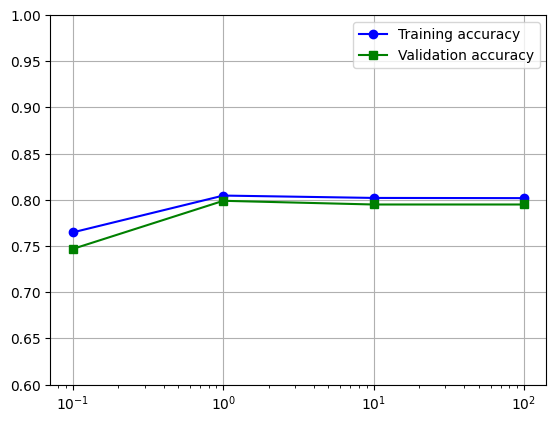

In [281]:
from sklearn.model_selection import validation_curve

train_scores, test_scores = validation_curve(estimator= best_lr_kpca_acc, X = X_train, y = y_train, cv  = 10, param_name = 'logisticregression__C', 
param_range = C_range)

train_mean = np.mean(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)

plt.plot(C_range, train_mean, color = 'blue', marker = 'o', label = 'Training accuracy')
plt.plot(C_range, test_mean, color = 'green', marker = 's', label = 'Validation accuracy')
plt.grid()
plt.xscale('log')
plt.ylim([0.6, 1.0])
plt.legend()
plt.show()

# Neural Network

In [282]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [283]:
x_train_orig, x_val, y_train_orig, y_val = train_test_split(X_train, y_train, random_state=1, test_size= 0.2, stratify= y_train)
magic_dict_train = {'features': x_train_orig, 'labels': y_train_orig}
magic_dict_test = {'features': X_test, 'labels': y_test}
ds_train_orig = tf.data.Dataset.from_tensor_slices(magic_dict_train)
ds_test = tf.data.Dataset.from_tensor_slices(magic_dict_test)

In [284]:
#ds_train_ = ds_train_.map(lambda x: (x['features'], x['labels']))
ds_test = ds_test.map(lambda x: (x['features'], x['labels']))
#ds_val_orig = ds_val_orig.map(lambda x: (x['features'], x['labels']))
ds_train_orig = ds_train_orig.map(lambda x: (x['features'], x['labels']))

In [285]:
num_epochs = 100    
training_size = len(ds_train_)  
batch_size = 2
ds_train = ds_train_.shuffle(buffer_size= training_size)
ds_train = ds_train.batch(batch_size = 2)
for i in range(5,21,5):
    for j in range(10,21,5):
        magic_model = tf.keras.Sequential([tf.keras.layers.Dense(i, activation = 'relu', name = 'fc2', input_shape= (10,)), 
        tf.keras.layers.Dense(j, activation = 'relu', name = 'fc1'),
        tf.keras.layers.Dense(1, name = 'fc3', activation = 'sigmoid')])
        magic_model.compile(optimizer= 'adam', loss = tf.keras.losses.BinaryCrossentropy() , metrics = [tf.keras.metrics.BinaryAccuracy()])
        history = magic_model.fit(ds_train, epochs= 150, verbose = 0, validation_data= (x_val, y_val))
        results = magic_model.get_metrics_result()
        print(i,j , results)

5 10 {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.397842>, 'binary_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.82>}
5 15 {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.4493376>, 'binary_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.815>}
5 20 {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.48629394>, 'binary_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.79>}
10 10 {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.391665>, 'binary_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.83>}
10 15 {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.32025623>, 'binary_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.845>}
10 20 {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.36988488>, 'binary_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.84>}
15 10 {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.42928207>, 'binary_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.83>}
15 15 {'loss': <tf.Tensor:

In [286]:
magic_model = tf.keras.Sequential([tf.keras.layers.Dense(10, activation = 'relu', name = 'fc1', input_shape= (10,)),
tf.keras.layers.Dense(20, activation = 'relu', name = 'fc2'),
tf.keras.layers.Dense(1, name = 'fc3', activation = 'sigmoid')])
magic_model.summary()

Model: "sequential_277"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 10)                110       
                                                                 
 fc2 (Dense)                 (None, 20)                220       
                                                                 
 fc3 (Dense)                 (None, 1)                 21        
                                                                 
Total params: 351 (1.37 KB)
Trainable params: 351 (1.37 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [287]:
magic_model.compile(optimizer= 'adam', loss = tf.keras.losses.BinaryCrossentropy() , metrics = [tf.keras.metrics.BinaryAccuracy()])
num_epochs = 100
training_size = len(ds_train_)
batch_size = 2
ds_train = ds_train_orig.shuffle(buffer_size= training_size)
ds_train = ds_train.repeat()
ds_train = ds_train.batch(batch_size = 2)
steps = np.ceil(training_size/batch_size)
history = magic_model.fit(ds_train, epochs= 200, verbose = 0, steps_per_epoch= steps)

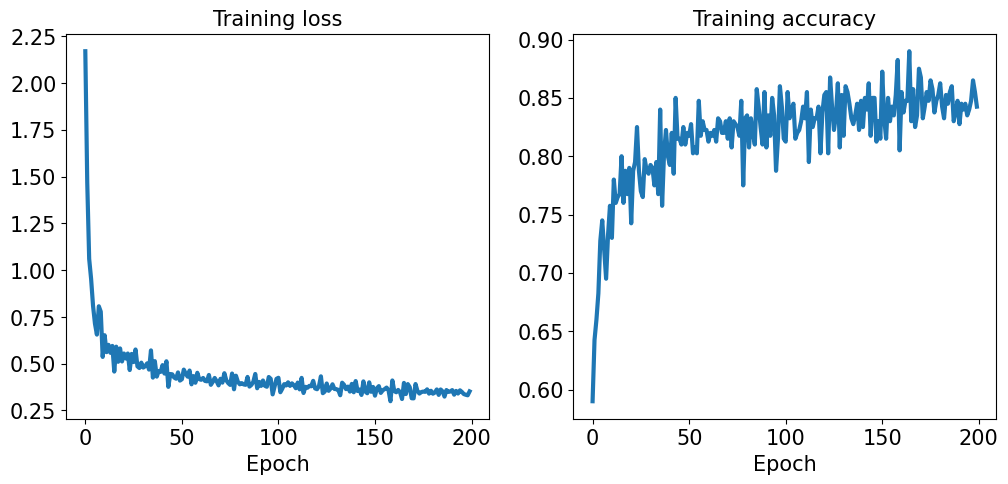

In [288]:
hist = history.history
fig = plt.figure(figsize= (12,5))
ax = fig.add_subplot(1,2,1)
ax.plot(hist['loss'], lw = 3)
ax.set_title('Training loss', size = 15)
ax.set_xlabel('Epoch',size = 15)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax = fig.add_subplot(1,2,2)
ax.plot(hist['binary_accuracy'], lw = 3)
ax.set_title('Training accuracy', size = 15)
ax.set_xlabel('Epoch', size = 15)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
plt.show()

In [289]:
results = magic_model.evaluate(ds_test.batch(10), verbose= 0)
print(results)

[0.5441938042640686, 0.8233333230018616]


In [290]:
magic_model = tf.keras.Sequential([tf.keras.layers.Dense(5, activation = 'sigmoid', name = 'fc1', input_shape= (10,)),
tf.keras.layers.Dense(20, activation = 'sigmoid', name = 'fc2'),
tf.keras.layers.Dense(1, name = 'fc3', activation = 'sigmoid')])
magic_model.compile(optimizer= 'adam', loss = tf.keras.losses.BinaryCrossentropy() , metrics = [tf.keras.metrics.BinaryAccuracy()])
num_epochs = 100
training_size = len(ds_train_)
batch_size = 2
ds_train = ds_train_orig.shuffle(buffer_size= training_size)
ds_train = ds_train.repeat()
ds_train = ds_train.batch(batch_size = 2)
steps = np.ceil(training_size/batch_size)
history = magic_model.fit(ds_train, epochs= 200, verbose = 0, steps_per_epoch= steps)

In [291]:
results = magic_model.evaluate(ds_test.batch(10), verbose= 0)
print(results)

[0.5110996961593628, 0.7400000095367432]


In [292]:
num_epochs = 100    
training_size = len(ds_train_)  
batch_size = 2
ds_train = ds_train_.shuffle(buffer_size= training_size)
ds_train = ds_train.batch(batch_size = 2)
for i in range(5,11,5):
    for j in range(i,31,5):
        magic_model = tf.keras.Sequential([tf.keras.layers.Dense(i, activation = 'relu', name = 'fc2', input_shape= (10,)), 
        tf.keras.layers.Dense(j, activation = 'relu', name = 'fc1'),
        tf.keras.layers.Dense(1, name = 'fc3', activation = 'sigmoid')])
        magic_model.compile(optimizer= 'adam', loss = tf.keras.losses.BinaryCrossentropy() , metrics = [tf.keras.metrics.BinaryAccuracy()])
        history = magic_model.fit(ds_train, epochs= 150, verbose = 0, validation_data= (x_val, y_val))
        results = magic_model.get_metrics_result()
        print(i,j , results)

5 5 {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.35626402>, 'binary_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.835>}
5 10 {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.46454242>, 'binary_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.805>}
5 15 {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.4369828>, 'binary_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.805>}
5 20 {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.35406247>, 'binary_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.845>}
5 25 {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.42273593>, 'binary_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.845>}
5 30 {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.4397909>, 'binary_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.83>}
10 10 {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.3586212>, 'binary_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.86>}
10 15 {'loss': <tf.Tensor

In [293]:
magic_model = tf.keras.Sequential([tf.keras.layers.Dense(5, activation = 'relu', name = 'fc1', input_shape= (10,)),
tf.keras.layers.Dense(25, activation = 'relu', name = 'fc2'),
tf.keras.layers.Dense(1, name = 'fc3', activation = 'sigmoid')])
magic_model.compile(optimizer= 'adam', loss = tf.keras.losses.BinaryCrossentropy() , metrics = [tf.keras.metrics.BinaryAccuracy()])
num_epochs = 100
training_size = len(ds_train_)
batch_size = 2
ds_train = ds_train_orig.shuffle(buffer_size= training_size)
ds_train = ds_train.repeat()
ds_train = ds_train.batch(batch_size = 2)
steps = np.ceil(training_size/batch_size)
history = magic_model.fit(ds_train, epochs= 200, verbose = 0, steps_per_epoch= steps)

In [294]:
results = magic_model.evaluate(ds_test.batch(10), verbose= 0)
print(results)
    


[0.46182143688201904, 0.8199999928474426]


# Ensamble


In [317]:
from sklearn.ensemble import BaggingClassifier


In [341]:
rfc_try = RandomForestClassifier(n_estimators= 5, max_depth= 5)
bag_rfc = BaggingClassifier(estimator = rfc_try, n_estimators = 150, max_samples = 1.0, max_features = 1.0, bootstrap = True, bootstrap_features = False, n_jobs = 1, random_state =1)

In [343]:
bag_rfc = bag_rfc.fit(X_train, y_train)
y_train_pred = bag_rfc.predict(X_train)
y_test_pred = bag_rfc.predict(X_test)
bag_rfc_train = accuracy_score(y_train, y_train_pred)
bag_rfc_test = accuracy_score(y_test, y_test_pred)

rfc_try = rfc_try.fit(X_train, y_train)
y_train_pred = rfc_try.predict(X_train)
y_test_pred = rfc_try.predict(X_test)
rfc_train = accuracy_score(y_train, y_train_pred)
rfc_test = accuracy_score(y_test, y_test_pred)
print('Bagging train/test accuracies %.3f/%.3f' % (bag_rfc_train, bag_rfc_test))
print('Rfc train/test accuracies %.3f/%.3f' % (rfc_train, rfc_test))
print('Rfc train/test f1 score %.3f/%.3f' % (scorer_f1(rfc_try, X_train, y_train), scorer_f1(rfc_try, X_test, y_test)))
print('Baggin train/test f1 score %.3f/%.3f' % (scorer_f1(bag_rfc, X_train, y_train), scorer_f1(bag_rfc, X_test, y_test)))

Bagging train/test accuracies 0.883/0.867
Rfc train/test accuracies 0.877/0.847
Rfc train/test f1 score 0.916/0.890
Baggin train/test f1 score 0.922/0.907


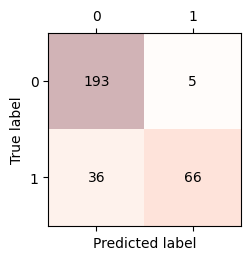

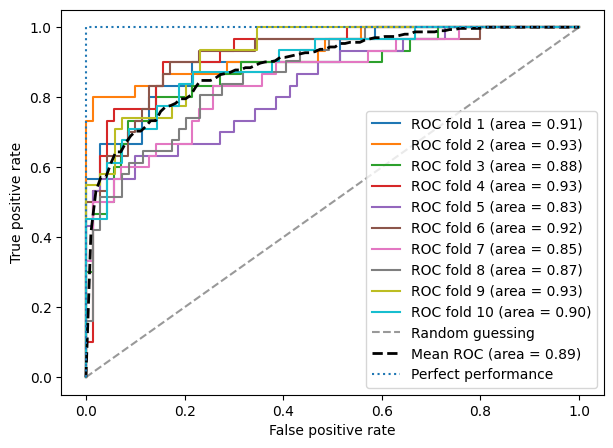

ROC auc score with accuracy 0.9187958011487424


In [320]:
confmat = confusion_matrix(y_true = y_test, y_pred = bag_rfc.predict(X_test))
fig, ax = plt.subplots(figsize = (2.5,2.5))
ax.matshow(confmat, cmap = plt.cm.Reds, alpha =0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x= j, y= i, s= confmat[i,j], va = 'center', ha = 'center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

ROC_Curve(X_train, y_train, bag_rfc)
print('ROC auc score with accuracy', roc_auc_score(y_true = y_test, y_score= bag_rfc.predict_proba(X_test)[:,1]))

In [347]:
lr_try = LogisticRegression(C = 100, max_iter=500, solver = 'lbfgs')
bag_lr = BaggingClassifier(estimator = lr_try, n_estimators = 150, max_samples = 1.0, max_features = 1.0, bootstrap = True, bootstrap_features = False, n_jobs = 1, random_state =1)

In [348]:
bag_lr = bag_lr.fit(X_train, y_train)
y_train_pred = bag_lr.predict(X_train)
y_test_pred = bag_lr.predict(X_test)
bag_lr_train = accuracy_score(y_train, y_train_pred)
bag_lr_test = accuracy_score(y_test, y_test_pred)

lr_try = lr_try.fit(X_train, y_train)
y_train_pred = lr_try.predict(X_train)
y_test_pred = lr_try.predict(X_test)
lr_train = accuracy_score(y_train, y_train_pred)
lr_test = accuracy_score(y_test, y_test_pred)
print('Bagging train/test accuracies %.3f/%.3f' % (bag_lr_train, bag_lr_test))
print('Lr train/test accuracies %.3f/%.3f' % (lr_train, lr_test))
print('Lr train/test f1 score %.3f/%.3f' % (scorer_f1(lr_try, X_train, y_train), scorer_f1(lr_try, X_test, y_test)))
print('Bagging train/test f1 score %.3f/%.3f' % (scorer_f1(bag_lr, X_train, y_train), scorer_f1(bag_lr, X_test, y_test)))

C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Bagging train/test accuracies 0.801/0.793
Lr train/test accuracies 0.803/0.793
Lr train/test f1 score 0.866/0.852
Bagging train/test f1 score 0.865/0.853


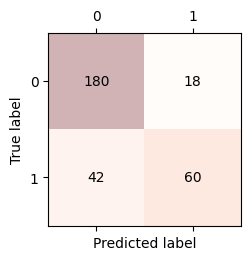

C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

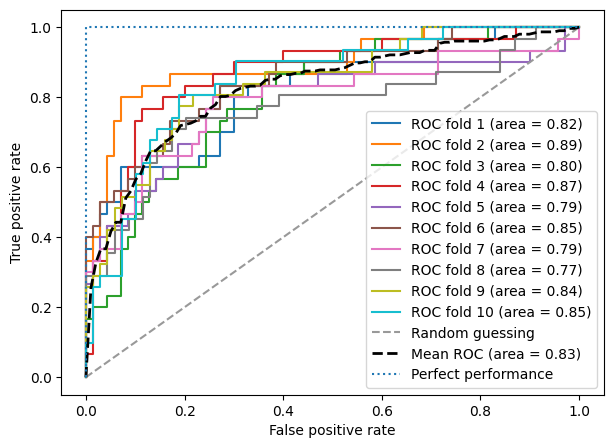

ROC auc score with accuracy 0.8493761140819964


In [323]:
confmat = confusion_matrix(y_true = y_test, y_pred = bag_lr.predict(X_test))
fig, ax = plt.subplots(figsize = (2.5,2.5))
ax.matshow(confmat, cmap = plt.cm.Reds, alpha =0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x= j, y= i, s= confmat[i,j], va = 'center', ha = 'center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

ROC_Curve(X_train, y_train, bag_lr)
print('ROC auc score with accuracy', roc_auc_score(y_true = y_test, y_score= bag_lr.predict_proba(X_test)[:,1]))

In [324]:
from sklearn.ensemble import AdaBoostClassifier
#tree = DecisionTreeClassifier(criterion = 'entropy', random_state= 1, max_depth= 1)


In [349]:
ada_lr = AdaBoostClassifier(base_estimator= lr_try, n_estimators= 200, random_state= 1)
ada_lr= ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_lr_train = accuracy_score(y_train, y_train_pred)
ada_lr_test = accuracy_score(y_test, y_test_pred)
print('AdaBoost train/test accuracies', (ada_lr_train, ada_lr_test))
print('Lr train/test accuracies', (lr_train, lr_test))
print('Lr train/test f1 score %.3f/%.3f' % (scorer_f1(lr_try, X_train, y_train), scorer_f1(lr_try, X_test, y_test)))
print('AdaBoost train/test f1 score %.3f/%.3f' % (scorer_f1(ada_lr, X_train, y_train), scorer_f1(ada_lr, X_test, y_test)))


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoost train/test accuracies (1.0, 0.87)
Lr train/test accuracies (0.803, 0.7933333333333333)
Lr train/test f1 score 0.866/0.852
AdaBoost train/test f1 score 1.000/0.906


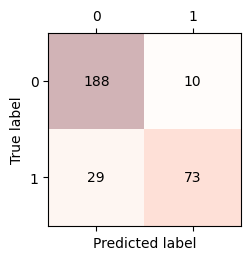

C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-pac

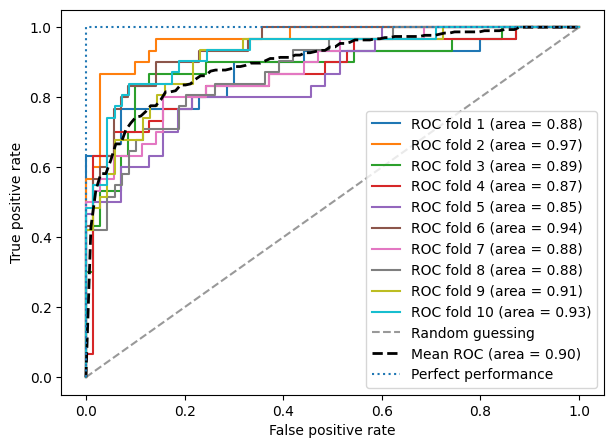

ROC auc score with accuracy 0.9080015844721727


In [350]:
confmat = confusion_matrix(y_true = y_test, y_pred = ada_lr.predict(X_test))
fig, ax = plt.subplots(figsize = (2.5,2.5))
ax.matshow(confmat, cmap = plt.cm.Reds, alpha =0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x= j, y= i, s= confmat[i,j], va = 'center', ha = 'center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

ROC_Curve(X_train, y_train, ada_lr)
print('ROC auc score with accuracy', roc_auc_score(y_true = y_test, y_score= ada_lr.predict_proba(X_test)[:,1]))

In [352]:
ada_rfc = AdaBoostClassifier(base_estimator = rfc_try, n_estimators = 100,  random_state = 1)
ada_rfc = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_rfc_train = accuracy_score(y_train, y_train_pred)
ada_rfc_test = accuracy_score(y_test, y_test_pred)
print('AdaBoost train/test accuracies', (ada_rfc_train, ada_rfc_test))
print('RFC train/test accuracies', (rfc_train, rfc_test))
print('RFC train/test f1 score %.3f/%.3f' % (scorer_f1(rfc_try, X_train, y_train), scorer_f1(rfc_try, X_test, y_test)))
print('AdaBoost train/test f1 score %.3f/%.3f' % (scorer_f1(ada_rfc, X_train, y_train), scorer_f1(ada_rfc, X_test, y_test)))

C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoost train/test accuracies (1.0, 0.87)
RFC train/test accuracies (0.877, 0.8466666666666667)
RFC train/test f1 score 0.916/0.890
AdaBoost train/test f1 score 1.000/0.906


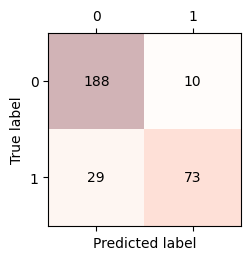

C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-pac

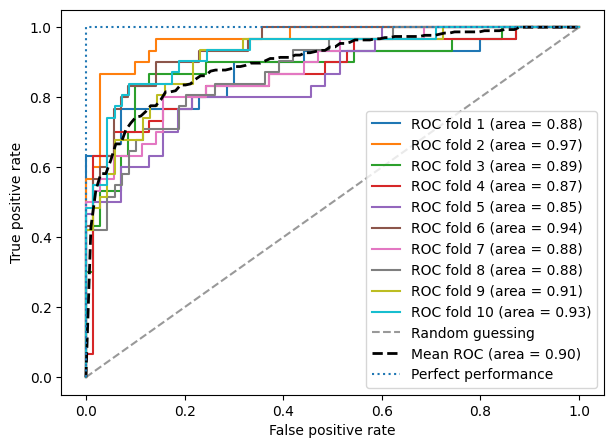

ROC auc score with accuracy 0.9080015844721727


In [353]:
confmat = confusion_matrix(y_true = y_test, y_pred = ada_rfc.predict(X_test))
fig, ax = plt.subplots(figsize = (2.5,2.5))
ax.matshow(confmat, cmap = plt.cm.Reds, alpha =0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x= j, y= i, s= confmat[i,j], va = 'center', ha = 'center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

ROC_Curve(X_train, y_train, ada_rfc)
print('ROC auc score with accuracy', roc_auc_score(y_true = y_test, y_score= ada_rfc.predict_proba(X_test)[:,1]))

## Clustering

In [6]:
from sklearn.cluster import KMeans 
from matplotlib import cm
from sklearn.metrics import silhouette_samples, silhouette_score


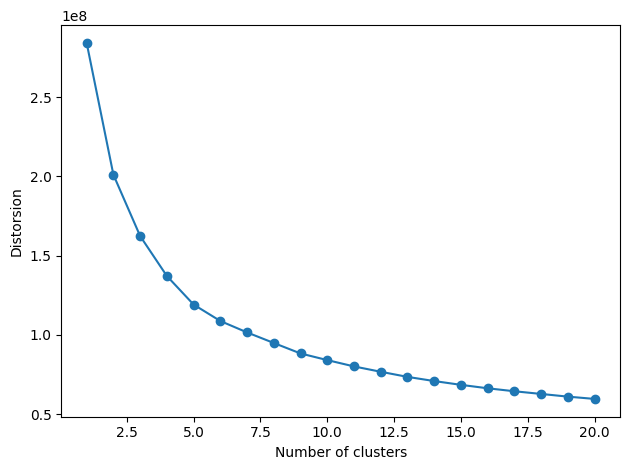

In [7]:
distorsions = []
for i in range(1,21):
    km = KMeans(n_clusters=i, init = 'k-means++', n_init = 50, max_iter= 300, random_state= 0)
    km.fit(X)
    distorsions.append(km.inertia_)
plt.plot(range(1,21), distorsions, marker = 'o')
plt.xlabel('Number of clusters')
plt.ylabel('Distorsion')
plt.tight_layout()
plt.show()

In [8]:
km = KMeans(n_clusters= 3, init= 'random', n_init= 50, max_iter= 300, tol = 1e-04, random_state= 0)
y_km = km.fit_predict(X)

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric = 'euclidean')

y_ax_lower, y_ax_upper = 0,0
yticks = []
for i,c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i)/n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height= 1.0, edgecolor = 'none', color = color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)

silhouette_avg = np.mean(c_silhouette_vals)
plt.axvline(silhouette_avg, color = 'red', linestyle = '--')
plt.yticks(yticks, cluster_labels +1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.xlim([0,0.9])
plt.tight_layout()
plt.show()

TypeError: KMeans.__init__() got an unexpected keyword argument 'class_weight'

In [ ]:
silhouette_score(X, y_km)

0.27822280566848884